## Loading the python packages

In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
# Load libraries
import os
import alpaca_trade_api as tradeapi
import numpy as np
import pandas as pd
from datetime import datetime
from pandas_datareader import data

from techanalysislib import SMA, EMA, ROC, MOM, RSI, STOK, STOD

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

#Libraries for Deep Learning Models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [70]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the data

Next, we extract the data required for our analysis using pandas datareader. 

In [71]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [72]:
# Set the Tesla tickers
ticker = ["FTNT"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp("2013-01-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-08-17", tz="America/New_York").isoformat()

# Get 1 year's worth of historical data for Tesla and Coca-Cola
df_ticker = alpaca.get_barset(
    ticker,
    timeframe,
    start=start_date,
    end=end_date,
    limit=1000,
).df

# Display sample data
df_ticker.count()

FTNT  open      1000
      high      1000
      low       1000
      close     1000
      volume    1000
dtype: int64

In [73]:
# shape of the data
df_ticker.tail()

FTNT                                  
                             open    high       low   close  volume
2021-08-11 00:00:00-04:00  301.16  302.98  293.7076  298.64  871783
2021-08-12 00:00:00-04:00  299.34  309.79  298.2800  305.59  897462
2021-08-13 00:00:00-04:00  303.94  309.53  302.2100  309.37  534405
2021-08-16 00:00:00-04:00  309.00  309.00  298.6700  302.60  689011
2021-08-17 00:00:00-04:00  301.67  302.27  295.1895  298.64  773167

## Data Preparation

In [74]:
stock_data = df_ticker.loc[:,'FTNT']
stock_data.head()

,open,high,low,close,volume
2017-08-28 00:00:00-04:00,37.21,37.32,37.0400,37.260,321998
2017-08-29 00:00:00-04:00,37.00,37.49,36.9500,37.365,399069
2017-08-30 00:00:00-04:00,37.39,37.90,37.2901,37.850,450683
2017-08-31 00:00:00-04:00,37.95,38.42,37.9100,38.220,727960
2017-09-01 00:00:00-04:00,38.41,38.61,38.0600,38.310,578823


In [75]:
#Checking for null values and removing the null values if any
print('Null Values =',stock_data.isnull().values.any())

Null Values = False


In [76]:
# Calculate daily return
stock_data['daily_return'] = stock_data['close'].pct_change()
stock_data['upside'] = np.where(stock_data['daily_return'] > 0, 1.0, 0.0)

stock_data.head()

,open,high,low,close,volume,daily_return,upside
2017-08-28 00:00:00-04:00,37.21,37.32,37.0400,37.260,321998,NaN,0.0
2017-08-29 00:00:00-04:00,37.00,37.49,36.9500,37.365,399069,0.002818,1.0
2017-08-30 00:00:00-04:00,37.39,37.90,37.2901,37.850,450683,0.012980,1.0
2017-08-31 00:00:00-04:00,37.95,38.42,37.9100,38.220,727960,0.009775,1.0
2017-09-01 00:00:00-04:00,38.41,38.61,38.0600,38.310,578823,0.002355,1.0


## Feature Engineering

Our approach is based on price momentum. We will derive momentum fatures that will be used to predict future signals.

The current Data consists of date, open, high, low, close and volume. Following momentum indicatord are calculated using this data. 
* **Exponential Moving Average** : provides an indication of the overall trend of the price movement by smooting high volatility of the price movement.  
* **Stochastic Oscillator %K and %D** : a momentum indicator that compares a closing price to a range of its prices over a certain period of time. %K and %D are slow and fast indicators.
* **Relative Strength Index(RSI)** : a momentum indicator that measures the magnitude of recent price changes and indicates if the stock is overbought or oversold. 
* **Rate Of Change(ROC)**: a momentum oscillator that measures the percentage change between the current price and the n period past price. 
* **Momentum (MOM)** : measure the speed at which the price is changing.

In [77]:
stock_data['EMA10'] = EMA(stock_data, 10)
stock_data['EMA30'] = EMA(stock_data, 30)
stock_data['EMA200'] = EMA(stock_data, 200)

In [78]:
stock_data['ROC10'] = ROC(stock_data['close'], 10)
stock_data['ROC30'] = ROC(stock_data['close'], 30)

In [79]:
stock_data['MOM10'] = MOM(stock_data['close'], 10)
stock_data['MOM30'] = MOM(stock_data['close'], 30)

In [80]:
stock_data['RSI10'] = RSI(stock_data['close'], 10)
stock_data['RSI30'] = RSI(stock_data['close'], 30)
stock_data['RSI200'] = RSI(stock_data['close'], 200)

In [81]:
stock_data['%D10'] = STOD(stock_data['close'], stock_data['low'], stock_data['high'], 10)
stock_data['%K30'] = STOK(stock_data['close'], stock_data['low'], stock_data['high'], 30)
stock_data['%D30'] = STOD(stock_data['close'], stock_data['low'], stock_data['high'], 30)
stock_data['%K200'] = STOK(stock_data['close'], stock_data['low'], stock_data['high'], 200)
stock_data['%D200'] = STOD(stock_data['close'], stock_data['low'], stock_data['high'], 200)

In [82]:
stock_data['MA10'] = SMA(stock_data, 10)
stock_data['MA30'] = SMA(stock_data, 30)
stock_data['MA200'] = SMA(stock_data, 200)

In [83]:
stock_data.tail(2)

,open,high,low,close,volume,daily_return,upside,EMA10,EMA30,EMA200,...,RSI30,RSI200,%D10,%K30,%D30,%K200,%D200,MA10,MA30,MA200
2021-08-16 00:00:00-04:00,309.00,309.00,298.6700,302.60,689011,-0.021883,0.0,299.007704,279.443762,204.199606,...,71.044430,62.624817,87.802342,88.796086,94.147716,96.458826,98.061137,302.321,276.632667,188.954196
2021-08-17 00:00:00-04:00,301.67,302.27,295.1895,298.64,773167,-0.013087,0.0,298.940848,280.682229,205.139354,...,68.440007,62.162141,67.398053,82.625362,90.262750,94.508471,96.920147,302.411,278.216000,189.857296


In [84]:
#excluding columns that are not needed for our prediction.
stock_data_bkup = stock_data.copy()
stock_data = stock_data.drop(['high','low','open','volume','daily_return'], axis=1)

In [85]:
stock_data = stock_data.dropna(axis=0)

In [86]:
stock_data.tail(2)

,close,upside,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%D10,%K30,%D30,%K200,%D200,MA10,MA30,MA200
2021-08-16 00:00:00-04:00,302.60,0.0,299.007704,279.443762,204.199606,1.632297,20.490563,17.98,54.55,66.759996,71.044430,62.624817,87.802342,88.796086,94.147716,96.458826,98.061137,302.321,276.632667,188.954196
2021-08-17 00:00:00-04:00,298.64,0.0,298.940848,280.682229,205.139354,-1.769620,17.885762,0.90,47.50,60.574804,68.440007,62.162141,67.398053,82.625362,90.262750,94.508471,96.920147,302.411,278.216000,189.857296


## Data Visualization

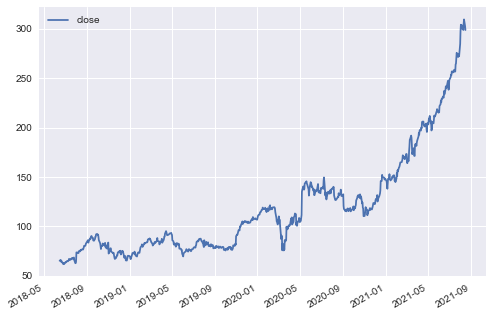

In [87]:
stock_data[['close']].plot(grid=True)
plt.show()

In [88]:
stock_data=stock_data.drop(['close'], axis=1)

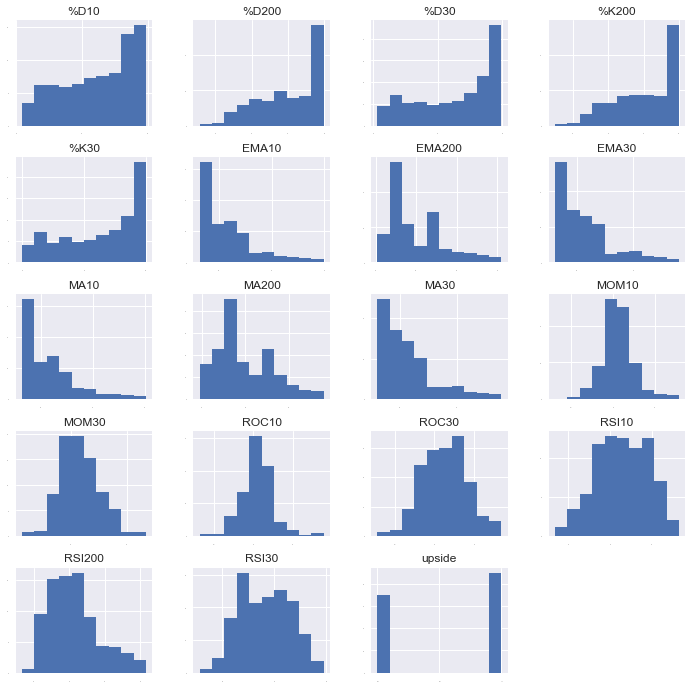

In [89]:
# histograms to understand how data is distributed
stock_data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

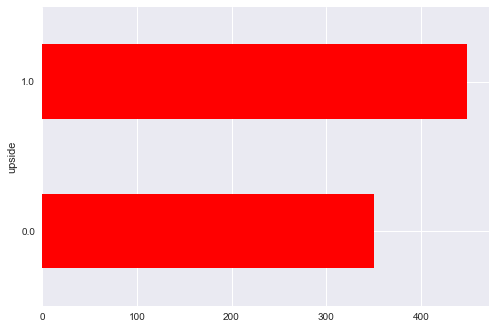

In [90]:
fig = plt.figure()
plot = stock_data.groupby(['upside']).size().plot(kind='barh', color='red')
plt.show()

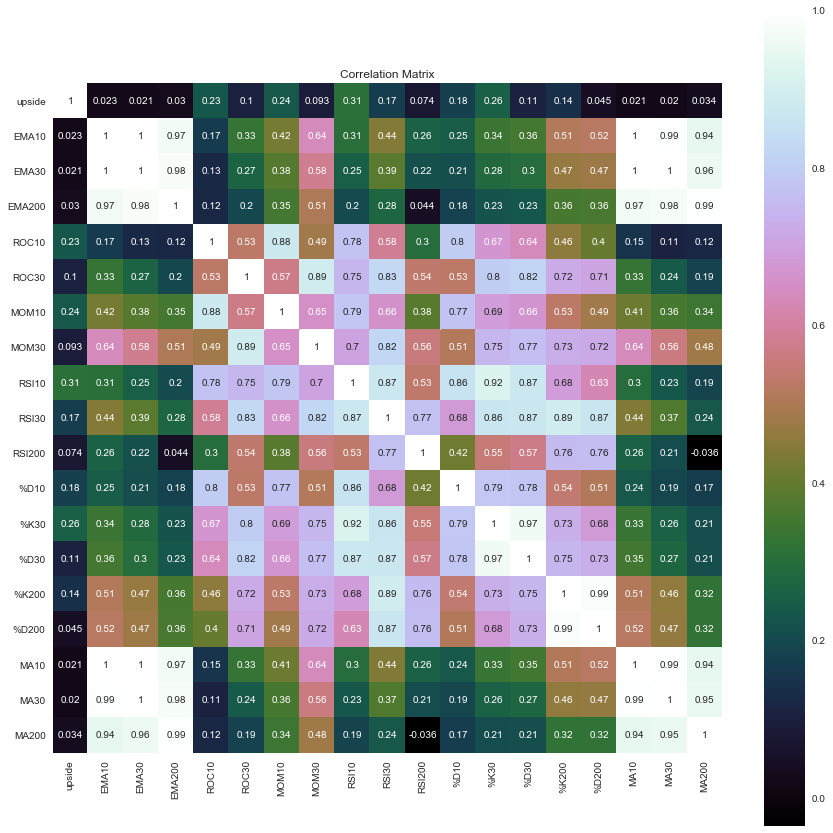

In [91]:
# correlation
correlation = stock_data.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

# Model training and evaluation

In [92]:
# Construct training start and end dates
training_start = stock_data.index.min().strftime(format= '%Y-%m-%d')
training_end = '2020-09-30'

# Construct testing start and end dates
testing_start =  '2020-08-01'
testing_end = stock_data.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2018-06-15
Training End: 2020-09-30
Testing Start: 2020-08-01
Testing End: 2021-08-17


In [93]:
# split out validation dataset for the end
y_train = stock_data["upside"][training_start:training_end]
X_train = stock_data.loc[:, stock_data.columns != 'upside'][training_start:training_end]

y_test = stock_data["upside"][testing_start:testing_end]
X_test = stock_data.loc[:, stock_data.columns != 'upside'][testing_start:testing_end]

In [94]:
# Standard scaling
scaler = StandardScaler().fit(X_train)
rescaledX_train = scaler.transform(X_train)
rescaledX_test = scaler.transform(X_test)

In [95]:
# evaluation metrics for classification
num_folds = 5
seed = 7
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring = 'roc_auc'

## Models

In [96]:
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))

#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('XGB', XGBClassifier()))

models.append(('RF', RandomForestClassifier(n_jobs=-1)))

In [97]:
models

[('LR', LogisticRegression(n_jobs=-1)),
 ('KNN', KNeighborsClassifier()),
 ('CART', DecisionTreeClassifier()),
 ('AB', AdaBoostClassifier()),
 ('XGB',
  XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
                colsample_bynode=None, colsample_bytree=None, gamma=None,
                gpu_id=None, importance_type='gain', interaction_constraints=None,
                learning_rate=None, max_delta_step=None, max_depth=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                random_state=None, reg_alpha=None, reg_lambda=None,
                scale_pos_weight=None, subsample=None, tree_method=None,
                validate_parameters=None, verbosity=None)),
 ('RF', RandomForestClassifier(n_jobs=-1))]

In [98]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, rescaledX_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.799355 (0.040065)
KNN: 0.579790 (0.057159)
CART: 0.664438 (0.034476)
AB: 0.716327 (0.064161)
[17:15:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:15:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:15:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

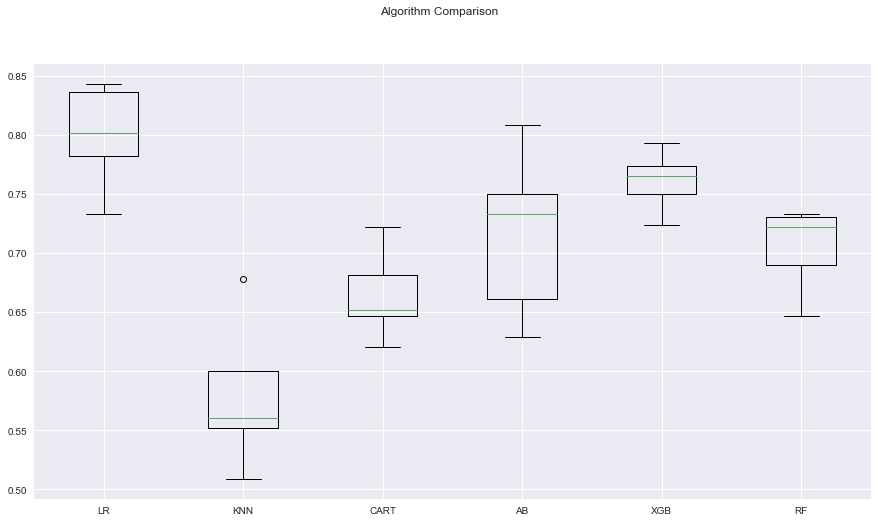

In [99]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

# RANDOM FOREST #

## Hyper Parameter Tuning for RandomForest with Grid Search

In [100]:
criterion = ["gini","entropy"]
n_estimators = [20,40,80]
max_depth = range(1,10)

param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX_train, y_train)


#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.716222 using {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 80}
#54 0.610660 (0.047585) with: {'criterion': 'gini', 'max_depth': 1, 'n_estimators': 20}
#44 0.629760 (0.035489) with: {'criterion': 'gini', 'max_depth': 1, 'n_estimators': 40}
#48 0.626237 (0.035776) with: {'criterion': 'gini', 'max_depth': 1, 'n_estimators': 80}
#46 0.627976 (0.031132) with: {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 20}
#49 0.622804 (0.032595) with: {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 40}
#50 0.622774 (0.032900) with: {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 80}
#38 0.641859 (0.036560) with: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 20}
#47 0.626312 (0.044123) with: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 40}
#41 0.633268 (0.039146) with: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 80}
#30 0.659280 (0.055763) with: {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 20}
#31 0.659220 (0.046192) with: {'criterion

## Fit the model and Run the trained model on the test dataset

In [133]:
# Setup the model based on the parameters suggested by Grid Search
model_rf = RandomForestClassifier(criterion='gini', max_depth=8, n_estimators=80) 
model_rf.fit(rescaledX_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=80)

In [134]:
# Accuracy metrics on the test set
predictions = model_rf.predict(rescaledX_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.7680608365019012
[[ 61  46]
 [ 15 141]]
              precision    recall  f1-score   support

         0.0       0.80      0.57      0.67       107
         1.0       0.75      0.90      0.82       156

    accuracy                           0.77       263
   macro avg       0.78      0.74      0.74       263
weighted avg       0.77      0.77      0.76       263



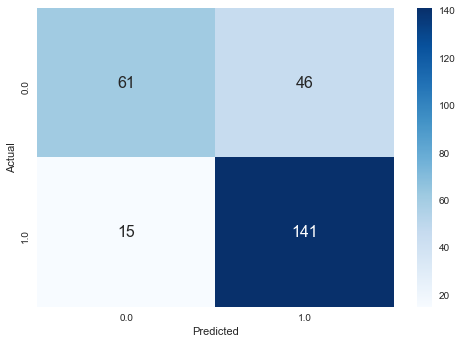

In [135]:
df_cm = pd.DataFrame(confusion_matrix(y_test, predictions), columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='d') # font size

Text(0.5, 0, 'Variable Importance')

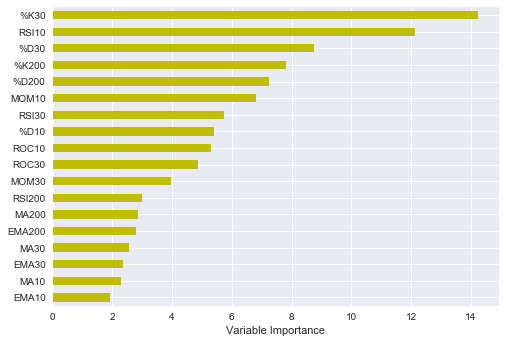

In [136]:
Importance = pd.DataFrame({'Importance':model_rf.feature_importances_*100}, index=X_train.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='y', legend=None )
plt.xlabel('Variable Importance')

# LOGISTIC REGRESSION 

## Hyper Parameter Tuning for Logistic Regression with Grid Search

In [105]:
#Grid Search for Logistic Regression to maximize recall
from sklearn.model_selection import GridSearchCV
model = LogisticRegression()
param_grid = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX_train, y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.799190 using {'C': 25, 'penalty': 'l2'}
#9 nan (nan) with: {'C': 0.001, 'penalty': 'l1'}
#8 0.589970 (0.033525) with: {'C': 0.001, 'penalty': 'l2'}
#10 nan (nan) with: {'C': 0.009, 'penalty': 'l1'}
#7 0.645307 (0.018444) with: {'C': 0.009, 'penalty': 'l2'}
#11 nan (nan) with: {'C': 0.01, 'penalty': 'l1'}
#6 0.653958 (0.027495) with: {'C': 0.01, 'penalty': 'l2'}
#12 nan (nan) with: {'C': 0.09, 'penalty': 'l1'}
#5 0.762879 (0.030982) with: {'C': 0.09, 'penalty': 'l2'}
#13 nan (nan) with: {'C': 1, 'penalty': 'l1'}
#4 0.794003 (0.035015) with: {'C': 1, 'penalty': 'l2'}
#14 nan (nan) with: {'C': 5, 'penalty': 'l1'}
#2 0.795742 (0.035038) with: {'C': 5, 'penalty': 'l2'}
#15 nan (nan) with: {'C': 10, 'penalty': 'l1'}
#3 0.795712 (0.034817) with: {'C': 10, 'penalty': 'l2'}
#16 nan (nan) with: {'C': 25, 'penalty': 'l1'}
#1 0.799190 (0.030463) with: {'C': 25, 'penalty': 'l2'}


## Fit the model and Run the trained model on the test dataset

In [137]:
# Setup the model based on the parameters suggested by Grid Search
model_lr = LogisticRegression(penalty = 'l2',C = 25)
model_lr.fit(rescaledX_train, y_train)

LogisticRegression(C=25)

In [138]:
# Accuracy metrics on the test set
predictions = model_lr.predict(rescaledX_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.7300380228136882
[[ 40  67]
 [  4 152]]
              precision    recall  f1-score   support

         0.0       0.91      0.37      0.53       107
         1.0       0.69      0.97      0.81       156

    accuracy                           0.73       263
   macro avg       0.80      0.67      0.67       263
weighted avg       0.78      0.73      0.70       263



Text(0.5, 0, 'Variable Importance')

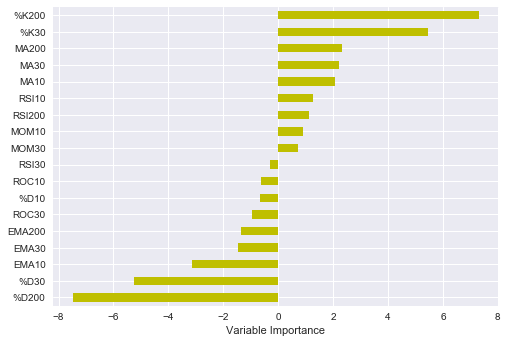

In [139]:
coeff = model_lr.coef_
cols = X_train.columns.values
#Importance = pd.DataFrame({'Importance':coeff.reshape(18,1)}, index=X_train.columns)
#Importance

Importance = pd.DataFrame(coeff.reshape(18,-1), index = cols)
Importance['Importance'] = Importance.iloc[:,0]

Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='y',legend=None )
plt.xlabel('Variable Importance')

# ADA BOOST

## Hyper Parameter Tuning for Adaboost with Grid Search

In [109]:
n_estimators = [40,80,200]
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.5]

param_grid = dict(n_estimators=n_estimators, learning_rate=learning_rate)
kfold = KFold(n_splits=num_folds)

# Instantiate GridSearchCV, fit model and make prediction
model = AdaBoostClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX_train, y_train)


#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.721439 using {'learning_rate': 0.5, 'n_estimators': 40}
#13 0.574378 (0.051733) with: {'learning_rate': 0.001, 'n_estimators': 40}
#13 0.574378 (0.051733) with: {'learning_rate': 0.001, 'n_estimators': 80}
#13 0.574378 (0.051733) with: {'learning_rate': 0.001, 'n_estimators': 200}
#11 0.598636 (0.026896) with: {'learning_rate': 0.01, 'n_estimators': 40}
#11 0.598636 (0.026896) with: {'learning_rate': 0.01, 'n_estimators': 80}
#10 0.605517 (0.031060) with: {'learning_rate': 0.01, 'n_estimators': 200}
#9 0.657346 (0.048633) with: {'learning_rate': 0.1, 'n_estimators': 40}
#6 0.676417 (0.026097) with: {'learning_rate': 0.1, 'n_estimators': 80}
#2 0.697196 (0.036065) with: {'learning_rate': 0.1, 'n_estimators': 200}
#7 0.672954 (0.036515) with: {'learning_rate': 0.2, 'n_estimators': 40}
#4 0.688486 (0.046756) with: {'learning_rate': 0.2, 'n_estimators': 80}
#3 0.695397 (0.046329) with: {'learning_rate': 0.2, 'n_estimators': 200}
#1 0.721439 (0.034410) with: {'learning_rate': 0.5, '

## Fit the model and Run the trained model on the test dataset

In [140]:
# Setup the model based on the parameters suggested by Grid Search
model_ab = AdaBoostClassifier(n_estimators=40, learning_rate=0.5)
model_ab.fit(rescaledX_train, y_train)

AdaBoostClassifier(learning_rate=0.5, n_estimators=40)

In [141]:
# Accuracy metrics on the test set
predictions = model_ab.predict(rescaledX_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.7680608365019012
[[ 76  31]
 [ 30 126]]
              precision    recall  f1-score   support

         0.0       0.72      0.71      0.71       107
         1.0       0.80      0.81      0.81       156

    accuracy                           0.77       263
   macro avg       0.76      0.76      0.76       263
weighted avg       0.77      0.77      0.77       263



Text(0.5, 0, 'Variable Importance')

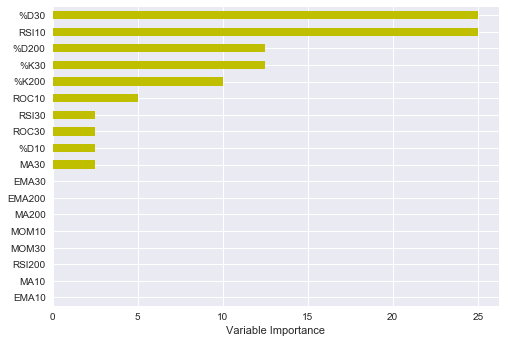

In [142]:
Importance = pd.DataFrame({'Importance':model_ab.feature_importances_*100}, index=X_train.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='y', legend=None )
plt.xlabel('Variable Importance')

# KNN classifier hyper parameter tuning

In [113]:
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]

#Convert to dictionary
param_grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

kfold = KFold(n_splits=num_folds)

# Instantiate GridSearchCV, fit model and make prediction
model = KNeighborsClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX_train, y_train)


#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.648666 using {'leaf_size': 1, 'n_neighbors': 3, 'p': 1}
#834 0.626282 (0.027762) with: {'leaf_size': 1, 'n_neighbors': 1, 'p': 1}
#2598 0.608921 (0.059512) with: {'leaf_size': 1, 'n_neighbors': 1, 'p': 2}
#2696 0.589925 (0.031622) with: {'leaf_size': 1, 'n_neighbors': 2, 'p': 1}
#2794 0.572474 (0.057863) with: {'leaf_size': 1, 'n_neighbors': 2, 'p': 2}
#1 0.648666 (0.055848) with: {'leaf_size': 1, 'n_neighbors': 3, 'p': 1}
#99 0.641739 (0.051190) with: {'leaf_size': 1, 'n_neighbors': 3, 'p': 2}
#246 0.634918 (0.062863) with: {'leaf_size': 1, 'n_neighbors': 4, 'p': 1}
#2745 0.589805 (0.046773) with: {'leaf_size': 1, 'n_neighbors': 4, 'p': 2}
#344 0.633178 (0.052309) with: {'leaf_size': 1, 'n_neighbors': 5, 'p': 1}
#589 0.631394 (0.039067) with: {'leaf_size': 1, 'n_neighbors': 5, 'p': 2}
#1912 0.619295 (0.063278) with: {'leaf_size': 1, 'n_neighbors': 6, 'p': 1}
#2304 0.612414 (0.049243) with: {'leaf_size': 1, 'n_neighbors': 6, 'p': 2}
#2108 0.614123 (0.064164) with: {'leaf_size':

## Fit the model and Run the trained model on the test dataset

In [143]:
# Setup the model based on the parameters suggested by Grid Search
model_knn = KNeighborsClassifier(leaf_size=1, n_neighbors=3, p=1)
model_knn.fit(rescaledX_train, y_train)

KNeighborsClassifier(leaf_size=1, n_neighbors=3, p=1)

In [144]:
# Accuracy metrics on the test set
predictions = model_knn.predict(rescaledX_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.6768060836501901
[[ 36  71]
 [ 14 142]]
              precision    recall  f1-score   support

         0.0       0.72      0.34      0.46       107
         1.0       0.67      0.91      0.77       156

    accuracy                           0.68       263
   macro avg       0.69      0.62      0.61       263
weighted avg       0.69      0.68      0.64       263



# DECISION TREE

## Decision Tree Hyper Parameter Tuning

In [116]:
criterion = ["gini","entropy"]
max_depth = range(1,10)
min_samples_split = range(1,10)
min_samples_leaf = range(1,5)

param_grid = dict(criterion = criterion, max_depth=max_depth, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf)
model = DecisionTreeClassifier()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX_train, y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.733598 using {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}
#648 nan (nan) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 1}
#513 0.574378 (0.051733) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
#513 0.574378 (0.051733) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 3}
#513 0.574378 (0.051733) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 4}
#513 0.574378 (0.051733) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 5}
#513 0.574378 (0.051733) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 6}
#513 0.574378 (0.051733) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 7}
#513 0.574378 (0.051733) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 

In [145]:
# Setup the model based on the parameters suggested by Grid Search
model_cart = DecisionTreeClassifier(criterion = 'gini', max_depth = 5, min_samples_leaf = 2, min_samples_split = 5)
model_cart.fit(rescaledX_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=5)

In [146]:
# Accuracy metrics on the test set
predictions = model_cart.predict(rescaledX_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.7338403041825095
[[ 87  20]
 [ 50 106]]
              precision    recall  f1-score   support

         0.0       0.64      0.81      0.71       107
         1.0       0.84      0.68      0.75       156

    accuracy                           0.73       263
   macro avg       0.74      0.75      0.73       263
weighted avg       0.76      0.73      0.74       263



Text(0.5, 0, 'Variable Importance')

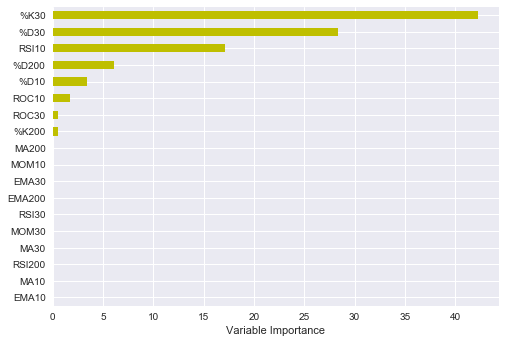

In [147]:
Importance = pd.DataFrame({'Importance':model_cart.feature_importances_*100}, index=X_train.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='y', legend=None )
plt.xlabel('Variable Importance')

In [148]:
import graphviz
from sklearn import tree

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

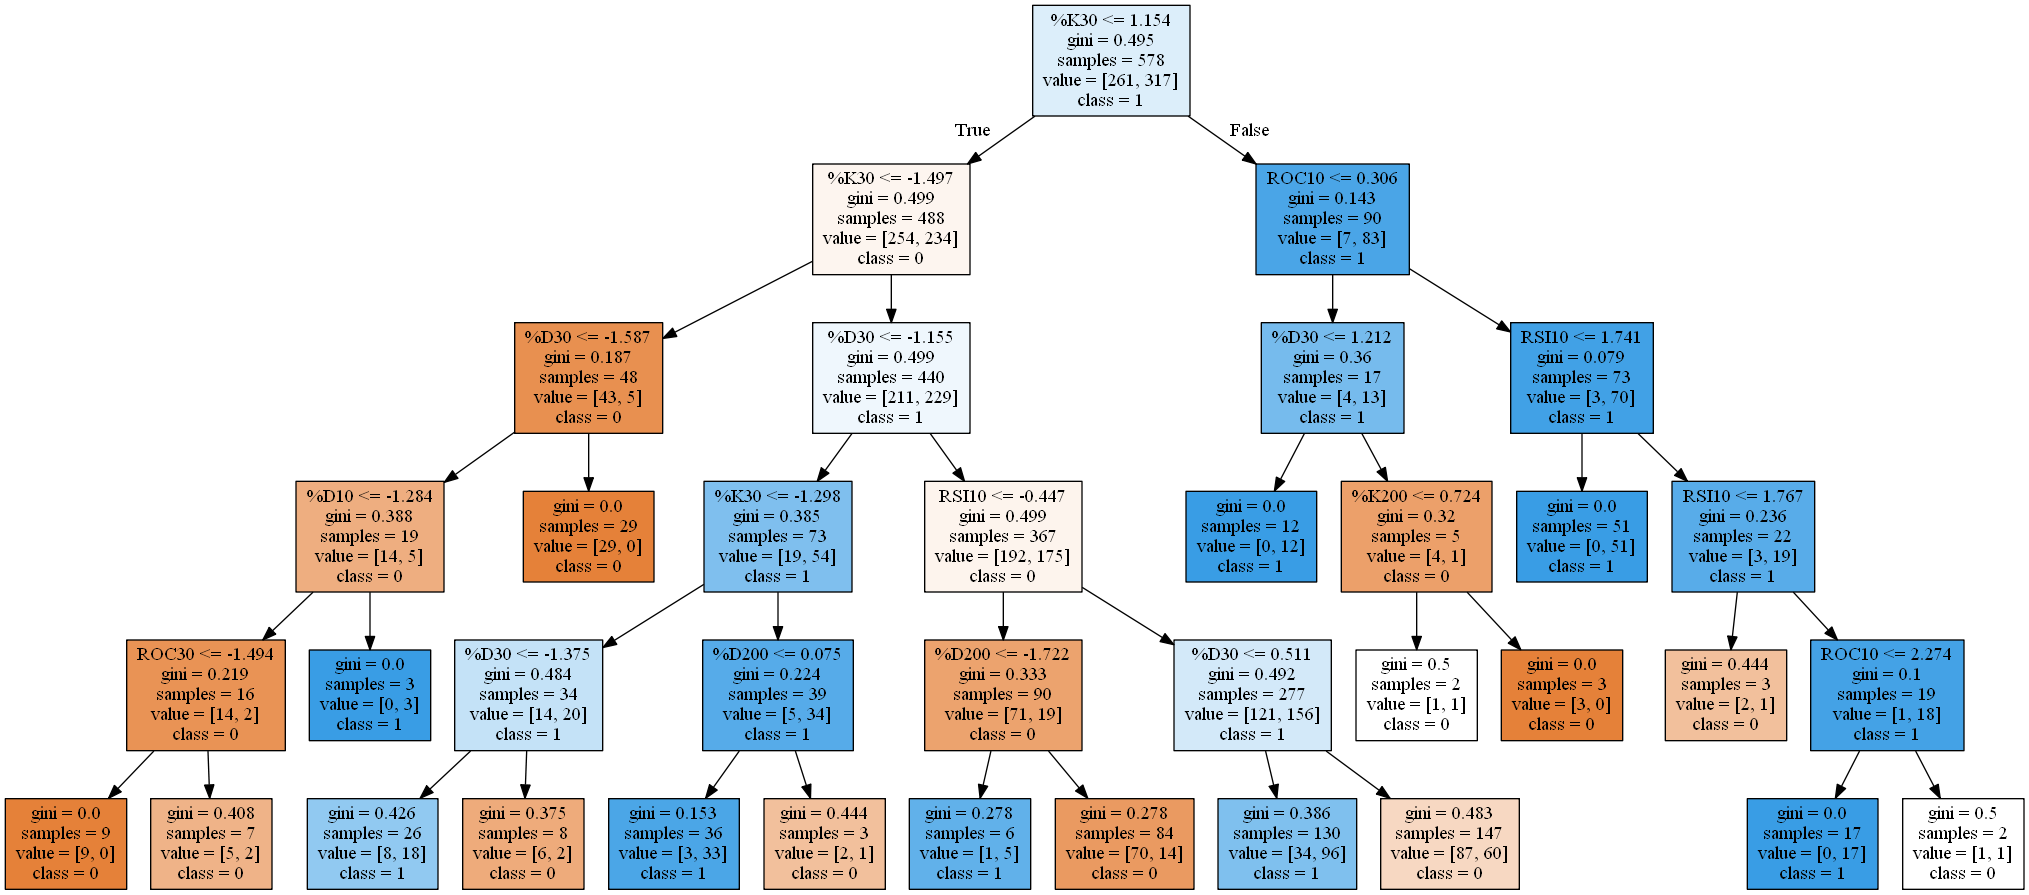

In [149]:
# Create DOT data
dot_data = tree.export_graphviz(
    model_cart, out_file=None, feature_names=X_train.columns, class_names=["0", "1"], filled=True
)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())

# XGBoost hyperparameter optimization

In [122]:
'''
max_depth = [3, 5, 6, 10, 15, 20]
learning_rate = [0.01, 0.1, 0.2, 0.3]
subsample = np.arange(0.5, 1.0, 0.1)
colsample_bytree = np.arange(0.4, 1.0, 0.1)
colsample_bylevel = np.arange(0.4, 1.0, 0.1)
n_estimators = [100, 500, 1000]

param_grid = dict(max_depth = max_depth, learning_rate = learning_rate, subsample = subsample, colsample_bytree = colsample_bytree, 
                 colsample_bylevel = colsample_bylevel, n_estimators = n_estimators)
model = XGBClassifier()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))
    '''

'\nmax_depth = [3, 5, 6, 10, 15, 20]\nlearning_rate = [0.01, 0.1, 0.2, 0.3]\nsubsample = np.arange(0.5, 1.0, 0.1)\ncolsample_bytree = np.arange(0.4, 1.0, 0.1)\ncolsample_bylevel = np.arange(0.4, 1.0, 0.1)\nn_estimators = [100, 500, 1000]\n\nparam_grid = dict(max_depth = max_depth, learning_rate = learning_rate, subsample = subsample, colsample_bytree = colsample_bytree, \n                 colsample_bylevel = colsample_bylevel, n_estimators = n_estimators)\nmodel = XGBClassifier()\nkfold = KFold(n_splits=num_folds)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)\ngrid_result = grid.fit(rescaledX, y_train)\n\n#Print Results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nranks = grid_result.cv_results_[\'rank_test_score\']\nfor mean, stdev, param, rank in zip(means

In [150]:
# Train XGB classifier with default hyper parameters
model_xgb = XGBClassifier()
model_xgb.fit(rescaledX_train, y_train)

[17:23:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [151]:
# Accuracy metrics on the test set
predictions = model_xgb.predict(rescaledX_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.8288973384030418
[[ 79  28]
 [ 17 139]]
              precision    recall  f1-score   support

         0.0       0.82      0.74      0.78       107
         1.0       0.83      0.89      0.86       156

    accuracy                           0.83       263
   macro avg       0.83      0.81      0.82       263
weighted avg       0.83      0.83      0.83       263



# AUC-ROC curve for all classification models

In [152]:
# predict probabilities
pred_prob_rf = model_rf.predict_proba(rescaledX_test)
pred_prob_lr = model_lr.predict_proba(rescaledX_test)
pred_prob_ab = model_ab.predict_proba(rescaledX_test)
pred_prob_knn = model_knn.predict_proba(rescaledX_test)
pred_prob_cart = model_cart.predict_proba(rescaledX_test)
pred_prob_xgb = model_xgb.predict_proba(rescaledX_test)

In [153]:
from sklearn.metrics import roc_curve
# roc curve for models
fpr_rf, tpr_rf, thresh_rf = roc_curve(y_test, pred_prob_rf[:,1], pos_label=1)
fpr_lr, tpr_lr, thresh_lr = roc_curve(y_test, pred_prob_lr[:,1], pos_label=1)
fpr_ab, tpr_ab, thresh_ab = roc_curve(y_test, pred_prob_ab[:,1], pos_label=1)
fpr_knn, tpr_knn, thresh_knn = roc_curve(y_test, pred_prob_knn[:,1], pos_label=1)
fpr_cart, tpr_cart, thresh_cart = roc_curve(y_test, pred_prob_cart[:,1], pos_label=1)
fpr_xgb, tpr_xgb, thresh_xgb = roc_curve(y_test, pred_prob_xgb[:,1], pos_label=1)

In [154]:
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

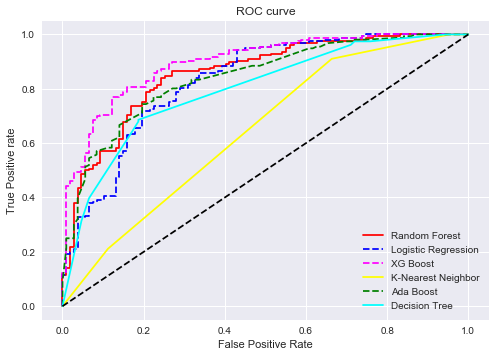

In [155]:
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr_rf, tpr_rf, linestyle='-',color='red', label='Random Forest')
plt.plot(fpr_lr, tpr_lr, linestyle='--',color='blue', label='Logistic Regression')
plt.plot(fpr_xgb, tpr_xgb, linestyle='--',color='magenta', label='XG Boost')
plt.plot(fpr_knn, tpr_knn, linestyle='-',color='yellow', label='K-Nearest Neighbor')
plt.plot(fpr_ab, tpr_ab, linestyle='--',color='green', label='Ada Boost')
plt.plot(fpr_cart, tpr_cart, linestyle='-',color='cyan', label='Decision Tree')
plt.plot(p_fpr, p_tpr, linestyle='--', color='black')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [156]:
from sklearn.metrics import roc_auc_score

# auc scores
print(f"AUC score for Random Forest      : {roc_auc_score(y_test, pred_prob_rf[:,1])}")
print(f"AUC score for Logistic Regression: {roc_auc_score(y_test, pred_prob_lr[:,1])}")
print(f"AUC score for XG Boost           : {roc_auc_score(y_test, pred_prob_xgb[:,1])}")
print(f"AUC score for K-Nearest Neighbor : {roc_auc_score(y_test, pred_prob_knn[:,1])}")
print(f"AUC score for AdaBoost           : {roc_auc_score(y_test, pred_prob_ab[:,1])}")
print(f"AUC score for Decision Trees     : {roc_auc_score(y_test, pred_prob_cart[:,1])}")

AUC score for Random Forest      : 0.8554996405463695
AUC score for Logistic Regression: 0.8294991612748622
AUC score for XG Boost           : 0.8967768991133478
AUC score for K-Nearest Neighbor : 0.6445902228612509
AUC score for AdaBoost           : 0.8416307213036185
AUC score for Decision Trees     : 0.7964893362089623


# Final Model

In [157]:
# Accuracy metrics on the test set
predictions = model_xgb.predict(rescaledX_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.8288973384030418
[[ 79  28]
 [ 17 139]]
              precision    recall  f1-score   support

         0.0       0.82      0.74      0.78       107
         1.0       0.83      0.89      0.86       156

    accuracy                           0.83       263
   macro avg       0.83      0.81      0.82       263
weighted avg       0.83      0.83      0.83       263



In [158]:
predictions

array([1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1.,
       1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1.,
       1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 0., 0.

# BACKTESTING

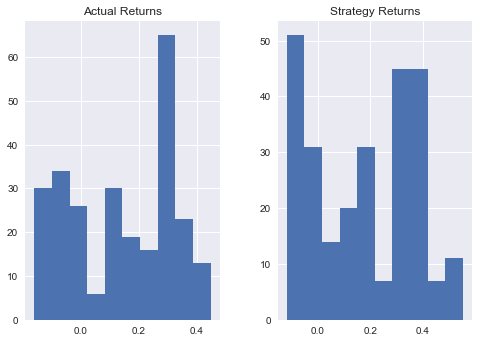

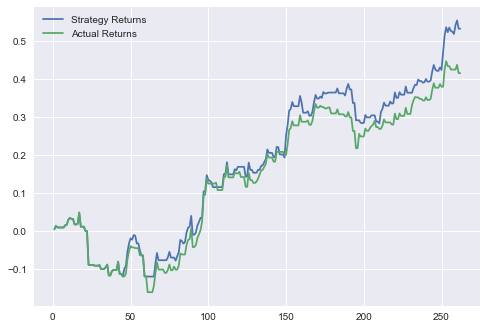

In [159]:
#Create column for Strategy Returns by multiplying the daily returns by the position held at close of business the previous day
backtestdata = pd.DataFrame(index=X_test.index)
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = y_test
test_close_data = stock_data_bkup[testing_start:testing_end]
backtestdata['Market Returns'] = test_close_data['close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()